In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 10.1 MB/s eta 0:00:00


In [1]:
import zipfile
def unzip_file(zip_file):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall()

unzip_file("/content/drive/MyDrive/poldiv_500mb_aufbereitet.zip")

In [ ]:
import os
import torch
import torchvision
from torch import nn
from torchvision import datasets, models, transforms
from tifffile import imread
import torchvision.transforms as transforms

# Define parameters
device = 'cuda'
num_classes = 10
num_epochs = 70

# Define loader to load images
def loader(path):
    im = imread(path)
    return torch.as_tensor((im[:,:,:12])/4096).movedim(-1,0)#,-1,0)


# Load train dataset for as base for normalization 
dataset = datasets.DatasetFolder(root= '/content/poldiv_500mb_aufbereitet/train', loader=loader, extensions=['tiff','tif'])

# Calculate mean and std for normalization
mean = 0.
std = 0.
for image, label in dataset:
    mean += image.mean(dim=(1, 2))
    std += image.std(dim=(1, 2))

mean /= len(dataset)
std /= len(dataset)

# Define the data transform
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop((299,299)),
    torchvision.transforms.RandomRotation(45),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.Normalize(mean=mean, std=std)
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(299),
    torchvision.transforms.CenterCrop(299),
    torchvision.transforms.Normalize(mean=mean, std=std)
])

# Load the TIFF images from the train and test folders
train_dataset = datasets.DatasetFolder(root='/content/poldiv_500mb_aufbereitet/train', loader=loader, extensions=['tiff','tif'], transform=train_transforms)
test_dataset = datasets.DatasetFolder(root='/content/poldiv_500mb_aufbereitet/test', loader=loader, extensions=['tiff','tif'], transform=test_transforms)

# Define the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

# Get classes
classes = os.listdir(f"/content/poldiv_500mb_aufbereitet/train")

# Load the VGG16 model without the pretrained weights
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', weights=None)

# Change first convolutional layer and weights to process 12-channels
model.Conv2d_1a_3x3 = torch.nn.Conv2d(12, 32, kernel_size=3, stride=2, padding=2, bias=False)

#Modify the fully connected layer to output predictions for num_classes classes
model.fc = nn.Linear(2048, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# model on gpu
model.to(device)

# Train the model
for epoch in range(num_epochs):
    model.train() # set the model to training mode ---- Hier Änderungen überprüfen
    for inputs, labels in train_loader:
        # Move the inputs and labels to the device
        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        logits = outputs.logits
        loss = criterion(logits, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the average loss for this epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        # Move the inputs and labels to the device
        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print the test accuracy
    print(f'Test Accuracy of the model on the {total} test images: {100 * correct / total} %')

    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # True and predicted labels
    y_true = []
    y_pred = []

    # no gradients needed
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device, dtype=torch.float), labels.to(device)
            y_true.extend(labels.cpu().numpy())
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
            y_pred.extend(predictions.cpu().numpy())

    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.2f} %')

# save model
torch.save(model.state_dict(), './model.pth')

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.9/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

cf_matrix = confusion_matrix(y_true, y_pred)
dataframe = pd.DataFrame(cf_matrix, index=classes, columns=classes)

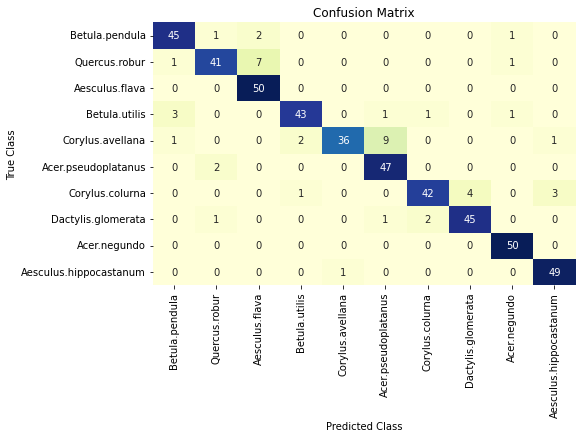

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
 
# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
 
plt.title("Confusion Matrix"), plt.tight_layout()
 
plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.savefig('cm.png')
plt.show()